# ML - Predicting Employee Productivity with Tree Models



For this project, we will be working on the [*Productivity Prediction of Garment Employees*](https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees) dataset from the UCI Machine Learning Repository. As described in the official summary:

> "The garment industry is one of the key examples of the industrial globalization of the modern era.
> 
> It is a highly labour-intensive industry with lots of manual processes. Satisfying the huge global demand for garment products is mostly dependent on the production and delivery performance of the employees in the garment manufacturing companies.
> 
> So, it is highly desirable among the decision-makers in the garments industry to track, analyze, and predict the productivity performance of the working teams in their factories.
> 
> This dataset can be used for regression purposes by predicting the productivity range (0-1) or for classification purposes by transforming the productivity range (0-1) into different classes."

In this exercise, we'll create trees for classifying the productivity of garment employees.

## Importing and Inspecting Data

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, multilabel_confusion_matrix, classification_report, get_scorer_names, make_scorer, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, ExtraTreesClassifier

from time import perf_counter

import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline
import seaborn as sns

In [2]:
garment = pd.read_csv('../Datasets/garments_worker_productivity.csv', parse_dates=['date'])

In [3]:
garment.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,2015-01-01,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,2015-01-01,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,2015-01-01,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,2015-01-01,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


### Column descriptions:

01. date : Date in YYYY-MM-DD
02. quarter : A portion of the month. A month was divided into four quarters 
03. department : Associated department with the instance
04. day : Day of the Week
05. team_ : Associated team number with the instance
06. targeted_productivity : Targeted productivity set by the Authority for each team for each day.
07. smv : Standard Minute Value, it is the allocated time for a task
08. wip : Work in progress. Includes the number of unfinished items for products
09. over_time : Represents the amount of overtime by each team in minutes
10. incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
11. idle_time : The amount of time when the production was interrupted due to several reasons
12. idle_men : The number of workers who were idle due to production interruption
13. no_of_style_change : Number of changes in the style of a particular product
14. no_of_workers : Number of workers in each team
15. actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1. 

### Column evaluations

Most columns given in the dataset seem useful for classifying productivity. That is, they seem like they could influence whether a project actually has high productivity. 

In [4]:
garment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   object        
 2   department             1197 non-null   object        
 3   day                    1197 non-null   object        
 4   team                   1197 non-null   int64         
 5   targeted_productivity  1197 non-null   float64       
 6   smv                    1197 non-null   float64       
 7   wip                    691 non-null    float64       
 8   over_time              1197 non-null   int64         
 9   incentive              1197 non-null   int64         
 10  idle_time              1197 non-null   float64       
 11  idle_men               1197 non-null   int64         
 12  no_of_style_change     1197 non-null   int64         
 13  no_

In [5]:
garment.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,691.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,1190.465991,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1837.455001,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,774.500000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,1039.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1252.500000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


A few weird numbers here. There are some *very* high `wip` values, indicating over 23K unfinished items for a project. It may be realistic for a very large project, but it's much higher than the average, so worth checking into. There are also some very high overtime rates--432 hours at maximum. This could be reasonable depending on the number of people on a team, which goes up to 89. If the high hours are on teams with lots of employees, it might not bee much overtime per employee. Actual productivity should range from 0 to 1, but it somehow goes over 1, which is problematic.

In [6]:
overproductive = garment[garment.actual_productivity > 1]
overproductive

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
337,2015-01-20,Quarter3,finishing,Tuesday,5,0.70,4.15,NaN,1440,0,0.0,0,0,8.0,1.033570
437,2015-01-26,Quarter4,finishing,Monday,3,0.75,3.94,NaN,1800,0,0.0,0,0,10.0,1.059621
456,2015-01-27,Quarter4,sweing,Tuesday,2,0.75,22.52,1635.0,6840,119,0.0,0,0,57.0,1.000230
457,2015-01-27,Quarter4,sweing,Tuesday,3,0.75,22.52,1299.0,6840,119,0.0,0,0,57.0,1.000230
477,2015-01-28,Quarter4,sweing,Wednesday,2,0.80,22.52,1559.0,6840,90,0.0,0,0,57.0,1.000230
478,2015-01-28,Quarter4,sweing,Wednesday,3,0.80,22.52,1350.0,6840,113,0.0,0,0,57.0,1.000230
498,2015-01-29,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230
518,2015-01-31,Quarter5,sweing,Saturday,3,0.80,22.52,1136.0,6960,113,0.0,0,0,58.0,1.000457
519,2015-01-31,Quarter5,sweing,Saturday,2,0.80,22.52,1397.0,6840,113,0.0,0,0,57.0,1.000230
542,2015-02-01,Quarter1,finishing,Sunday,8,0.65,4.15,NaN,960,0,0.0,0,0,8.0,1.011562


There isn't any clear trend in any column suggesting why these data might include higher than possible productivity rates, although interestingly, the rates are all different, suggesting they were rated over 1 on purpose or that they were calculated via an equation that allowed certain values to go over 1.

In [7]:
print(f"Missing Data: \n{garment.isnull().sum()}")

Missing Data: 
date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64


### Add productivity difference variable

In [8]:
garment['productivity_diff'] = garment['targeted_productivity'] - garment['actual_productivity'] 

Nearly half of all data is missing from the `wip` column.


In [9]:
val_cols = ['date', 'quarter', 'department', 'day', 'team', 'no_of_style_change']
for val in val_cols:
    print(val, garment[val].value_counts().sort_index(), '\n', sep='\n')

date
2015-01-01    19
2015-01-03    21
2015-01-04    21
2015-01-05    22
2015-01-06    21
2015-01-07    22
2015-01-08    22
2015-01-10    22
2015-01-11    23
2015-01-12    23
2015-01-13    22
2015-01-14    21
2015-01-15    19
2015-01-17    21
2015-01-18    19
2015-01-19    19
2015-01-20    15
2015-01-21    19
2015-01-22    22
2015-01-24    23
2015-01-25    21
2015-01-26    19
2015-01-27    21
2015-01-28    21
2015-01-29    20
2015-01-31    24
2015-02-01    19
2015-02-02    19
2015-02-03    19
2015-02-04    19
2015-02-05    18
2015-02-07    19
2015-02-08    19
2015-02-09    18
2015-02-10    19
2015-02-11    19
2015-02-12    19
2015-02-14    17
2015-02-15    19
2015-02-16    18
2015-02-17    20
2015-02-18    21
2015-02-19    20
2015-02-22    20
2015-02-23    19
2015-02-24    19
2015-02-25    21
2015-02-26    21
2015-02-28    21
2015-03-01    20
2015-03-02    20
2015-03-03    22
2015-03-04    21
2015-03-05    19
2015-03-07    19
2015-03-08    22
2015-03-09    22
2015-03-10    23
2015-03-1

The `department` column needs cleaning. It looks like there are sewing and finishing departments, but there are likely whitespaces next to some "finishing" instances, and "sewing" is consistently spelled incorrectly. No other important facts were gleaned here.

It's not clear whether there are enough observations in Quarter 5 of the `quarter` column to allow its inclusion. It may be more useful to exclude this variable. Also, why is there a quarter 5, when there should only be four?

The vast majority of items had no style changes, so even though `no_of_style_change` might be important for productivity, there is unlikely to be enough data to include this variable.

In [10]:
garment[garment.quarter=='Quarter5']

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productivity_diff
498,2015-01-29,Quarter5,sweing,Thursday,2,0.80,22.52,1416.0,6840,113,0.0,0,0,57.0,1.000230,-0.200230
499,2015-01-29,Quarter5,finishing,Thursday,4,0.80,4.30,NaN,1200,0,0.0,0,0,10.0,0.989000,-0.189000
500,2015-01-29,Quarter5,sweing,Thursday,3,0.80,22.52,1287.0,6840,100,0.0,0,0,57.0,0.950186,-0.150186
501,2015-01-29,Quarter5,sweing,Thursday,4,0.80,22.52,1444.0,6900,88,0.0,0,0,57.5,0.900800,-0.100800
502,2015-01-29,Quarter5,sweing,Thursday,10,0.80,22.52,1088.0,6720,88,0.0,0,0,56.0,0.900130,-0.100130
503,2015-01-29,Quarter5,finishing,Thursday,6,0.50,2.90,NaN,1200,0,0.0,0,0,10.0,0.899000,-0.399000
504,2015-01-29,Quarter5,finishing,Thursday,8,0.65,4.15,NaN,960,0,0.0,0,0,8.0,0.877552,-0.227552
505,2015-01-29,Quarter5,finishing,Thursday,11,0.60,2.90,NaN,960,0,0.0,0,0,8.0,0.864583,-0.264583
506,2015-01-29,Quarter5,finishing,Thursday,10,0.80,3.94,NaN,1200,0,0.0,0,0,10.0,0.856950,-0.056950
507,2015-01-29,Quarter5,finishing,Thursday,1,0.75,3.94,NaN,1200,0,0.0,0,0,10.0,0.853667,-0.103667


All "Quarter5" observations are on the 29-31st of the month. This category could therefore be merged with Quarter4.

In [11]:
numeric_cols = garment.drop(columns=val_cols).columns.tolist()
numeric_cols

['targeted_productivity',
 'smv',
 'wip',
 'over_time',
 'incentive',
 'idle_time',
 'idle_men',
 'no_of_workers',
 'actual_productivity',
 'productivity_diff']

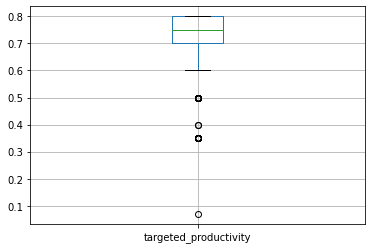

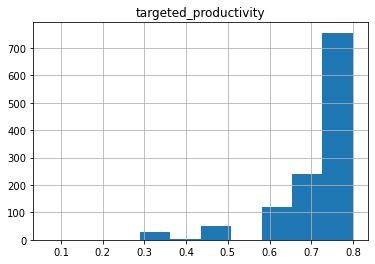

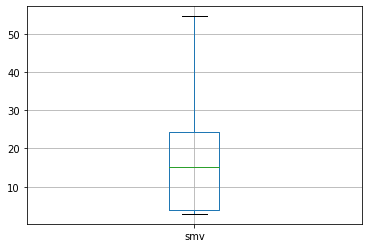

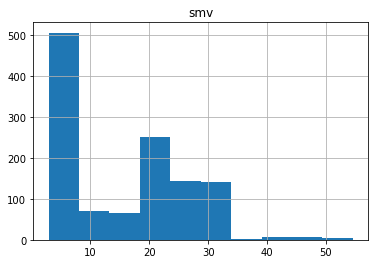

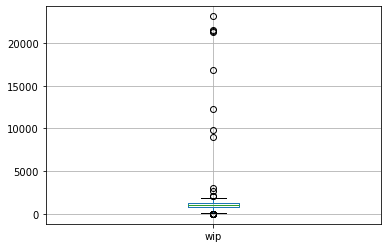

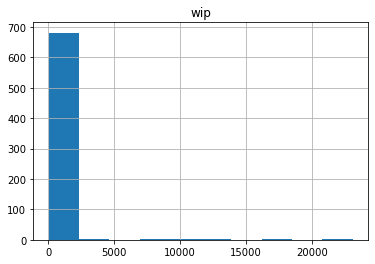

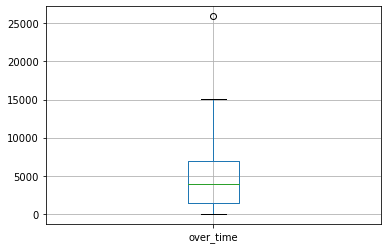

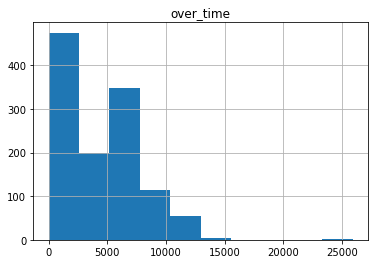

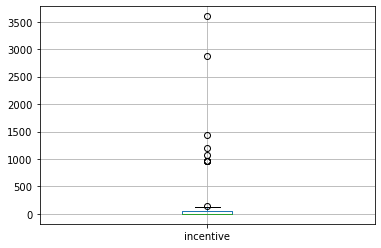

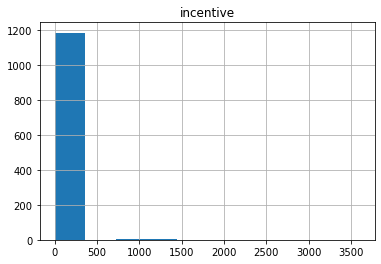

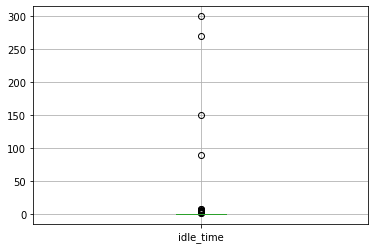

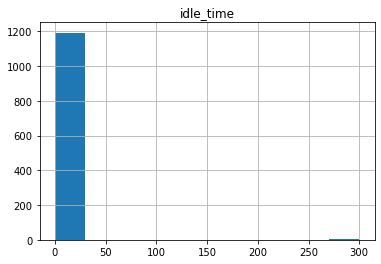

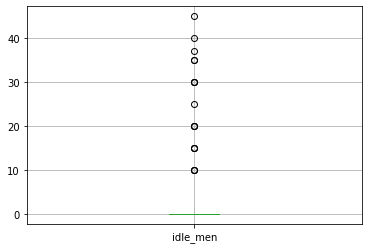

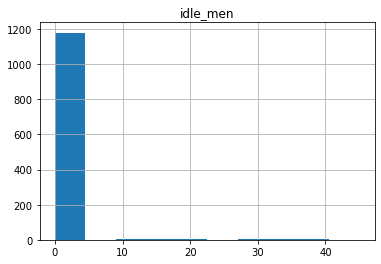

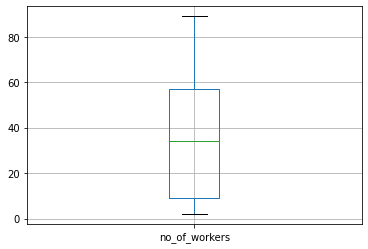

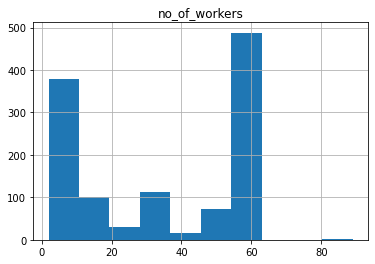

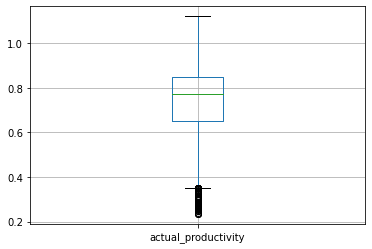

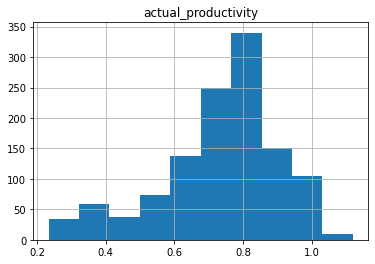

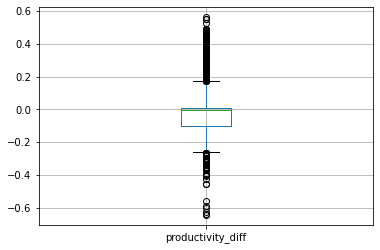

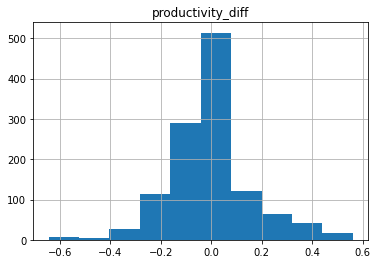

In [12]:
for col in numeric_cols:
    garment.boxplot(col)
    plt.show()
    garment.hist(col)
    plt.show()

There are some outliers in the numeric columns, but it's not clear that they're problematic.

However, there are several variables where most of the values are zero, and these should be excluded. They are: `wip`, `idle_men`, `idle_time`, and `incentive`.

It's also clear that a very large number of items have overtime.

In [13]:
print(
    f" Prop. with overtime: {round((garment[garment.over_time>1440].shape[0]/garment.shape[0]), 3)}\n",
    f"Prop. with no overtime: {round((garment[garment.over_time==0].shape[0]/garment.shape[0]), 3)}\n"
)

 Prop. with overtime: 0.695
 Prop. with no overtime: 0.026



About 70% of observations are over the 25th percentile of overtime for their team (24 hours), wheras only 3% of observations have no overtime.

In [14]:
print(
    f" Prop. exceeding productivity target: {round((garment[garment.productivity_diff<0].shape[0]/garment.shape[0]), 3)}\n",
    f"Prop. matching productivity target: {round((garment[garment.productivity_diff==0].shape[0]/garment.shape[0]), 3)}\n",
    f"Prop. not meeting productivity target: {round((garment[garment.productivity_diff>0].shape[0]/garment.shape[0]), 3)}"
)

 Prop. exceeding productivity target: 0.726
 Prop. matching productivity target: 0.005
 Prop. not meeting productivity target: 0.269


After seeing this, we might wonder how many projects met their productivity goals without overtime.

In [15]:
print(
    f" Prop. exceeding productivity goals without overtime: {round((garment[(garment.over_time==0) & (garment.productivity_diff<0)].shape[0]/garment.shape[0]), 3)}\n",
    f"Prop. exceeding productivity goals with < 24 hrs overtime: {round((garment[(garment.over_time<1440) & (garment.productivity_diff<0)].shape[0]/garment.shape[0]), 3)}\n"
)

 Prop. exceeding productivity goals without overtime: 0.02
 Prop. exceeding productivity goals with < 24 hrs overtime: 0.124



It seems to be rare indeed to meet or exceed productivity goals without overtime.

### Inspection Conclusions

It's clear from the descriptive statistics that the following columns should be excluded:
wip, idle_men, idle_time, incentive, and no_of_style_change. Date also doesn't seem worthwhile, as it's not a format that will be easy to deal with in the tree processing.

## Data cleaning

In [16]:
garment_mod = garment.copy()

### Fixing department column formatting

The two categories in the `department` column have issues. 
1. "finishing" is showing up twice, so there may be extra white space in some instances.
2. "sewing" is misspelled as "sweing"

In [17]:
garment_mod["department"].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

Stripping white space removes odd second 'finishing' category, so that will fix our problem with finishing.

In [18]:
garment_mod['department'] = garment_mod['department'].str.strip()

In [19]:
garment_mod['department'] = garment_mod['department'].replace("sweing", "sewing")

In [20]:
garment_mod['department'].value_counts()

sewing       691
finishing    506
Name: department, dtype: int64

### Merging Quarter5 & changing format

In [21]:
garment_mod.quarter = garment.quarter.replace('Quarter5', 'Quarter4')

In [22]:
garment_mod['quarter'] = garment_mod['quarter'].map({"Quarter1":'1', "Quarter2":'2', "Quarter3":'3', "Quarter4":'4'})

In [23]:
garment_mod.quarter.value_counts().sort_index()

1    360
2    335
3    210
4    292
Name: quarter, dtype: int64

### Make target productivity categorical

In [24]:
garment_mod['productive'] = garment_mod.actual_productivity >= garment_mod.targeted_productivity
garment_mod.tail()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productivity_diff,productive
1192,2015-03-11,2,finishing,Wednesday,10,0.75,2.9,NaN,960,0,0.0,0,0,8.0,0.628333,0.121667,False
1193,2015-03-11,2,finishing,Wednesday,8,0.70,3.9,NaN,960,0,0.0,0,0,8.0,0.625625,0.074375,False
1194,2015-03-11,2,finishing,Wednesday,7,0.65,3.9,NaN,960,0,0.0,0,0,8.0,0.625625,0.024375,False
1195,2015-03-11,2,finishing,Wednesday,9,0.75,2.9,NaN,1800,0,0.0,0,0,15.0,0.505889,0.244111,False
1196,2015-03-11,2,finishing,Wednesday,6,0.70,2.9,NaN,720,0,0.0,0,0,6.0,0.394722,0.305278,False


In [25]:
garment_mod = garment_mod.drop(columns=['wip', 'idle_men', 'idle_time', 'incentive', 'no_of_style_change', 'actual_productivity', 'productivity_diff', 'date'])
garment_mod.head()

,quarter,department,day,team,targeted_productivity,smv,over_time,no_of_workers,productive
0,1,sewing,Thursday,8,0.80,26.16,7080,59.0,True
1,1,finishing,Thursday,1,0.75,3.94,960,8.0,True
2,1,sewing,Thursday,11,0.80,11.41,3660,30.5,True
3,1,sewing,Thursday,12,0.80,11.41,3660,30.5,True
4,1,sewing,Thursday,6,0.80,25.90,1920,56.0,True


### Reordering columns

In [26]:
garment_mod = garment_mod[['quarter', 'day', 'department', 'team', 'no_of_workers', 'smv', 'over_time', 'targeted_productivity', 'productive']]

In [27]:
garment_mod.head()

,quarter,day,department,team,no_of_workers,smv,over_time,targeted_productivity,productive
0,1,Thursday,sewing,8,59.0,26.16,7080,0.80,True
1,1,Thursday,finishing,1,8.0,3.94,960,0.75,True
2,1,Thursday,sewing,11,30.5,11.41,3660,0.80,True
3,1,Thursday,sewing,12,30.5,11.41,3660,0.80,True
4,1,Thursday,sewing,6,56.0,25.90,1920,0.80,True


### Dummy encoding for categorical variables

In [28]:
cat_vars = ['quarter', 'day', 'department', 'team']

In [29]:
garment_dum = pd.get_dummies(data=garment_mod, columns=cat_vars, drop_first=True)
garment_dum.head()

,no_of_workers,smv,over_time,targeted_productivity,productive,quarter_2,quarter_3,quarter_4,day_Saturday,day_Sunday,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,59.0,26.16,7080,0.80,True,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,8.0,3.94,960,0.75,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,30.5,11.41,3660,0.80,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,30.5,11.41,3660,0.80,True,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,56.0,25.90,1920,0.80,True,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Building A Tree Model

In [30]:
garment_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   no_of_workers          1197 non-null   float64
 1   smv                    1197 non-null   float64
 2   over_time              1197 non-null   int64  
 3   targeted_productivity  1197 non-null   float64
 4   productive             1197 non-null   bool   
 5   quarter_2              1197 non-null   uint8  
 6   quarter_3              1197 non-null   uint8  
 7   quarter_4              1197 non-null   uint8  
 8   day_Saturday           1197 non-null   uint8  
 9   day_Sunday             1197 non-null   uint8  
 10  day_Thursday           1197 non-null   uint8  
 11  day_Tuesday            1197 non-null   uint8  
 12  day_Wednesday          1197 non-null   uint8  
 13  department_sewing      1197 non-null   uint8  
 14  team_2                 1197 non-null   uint8  
 15  team

In [31]:
X = garment_dum.drop(["productive"], axis=1)
y = garment_dum["productive"]

In [32]:
X[:2]

,no_of_workers,smv,over_time,targeted_productivity,quarter_2,quarter_3,quarter_4,day_Saturday,day_Sunday,day_Thursday,...,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,59.0,26.16,7080,0.80,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,8.0,3.94,960,0.75,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [33]:
y[:2]

0    True
1    True
Name: productive, dtype: bool

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    shuffle=True, 
                                                    random_state=444)
garment_class_tree = DecisionTreeClassifier(max_depth=3, random_state=444)
garment_class_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=444)

In [35]:
y_pred = garment_class_tree.predict(X_test)

### Inspecting our tree

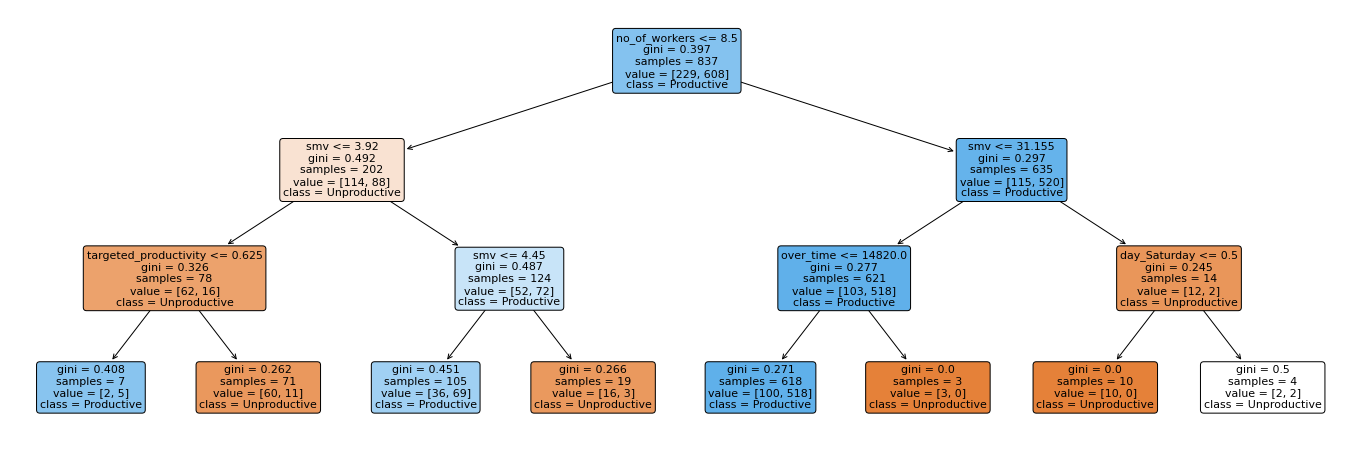

In [36]:
plt.figure(figsize = [24.0, 8.0])

_ = plot_tree(garment_class_tree, 
    feature_names = X.columns,
    class_names = ['Unproductive', 'Productive'], # had to input these manually, as the input classes are boolean
    filled = True,       
    proportion = False,
    precision = 3,
    rounded = True,
    fontsize = 11)

plt.show()

From the plot, we can see that SMV (allocated time for a task) is the variable most predictive of productivity--three of the seven parent nodes split on SMV. 

Let's see what some other metrics look like.

In [37]:
confusion_matrix(y_test, y_pred)

array([[ 28,  65],
       [  6, 261]], dtype=int64)

28 true negatives, 261 true positives, 6 false negatives, 65 false positives. We're slightly skewed toward false positives with this model.

In [38]:
print(f" Precision: {round(precision_score(y_test, y_pred), 3)}\n", 
     f"Recall: {round(recall_score(y_test, y_pred), 3)}\n",
      f"F1-score: {round(f1_score(y_test, y_pred), 3)}\n",
      f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}"
     )

 Precision: 0.801
 Recall: 0.978
 F1-score: 0.88
 Accuracy: 0.803


Our model's recall is fantastic, consistent with our model's positive skew, but the other metrics aren't quite as great. They're pretty good, but we can probably do better.

### Cross-validation

In [39]:
multiple_cross_scores = cross_validate(
                             garment_class_tree, 
                             X, y, cv = 10, 
                             scoring= ("accuracy","precision", "recall", "f1") )

In [40]:
multiple_cross_scores

{'fit_time': array([0.0059855 , 0.00399017, 0.00498581, 0.00801396, 0.00494909,
        0.00502682, 0.00498199, 0.00900984, 0.00498629, 0.00601435]),
 'score_time': array([0.00601888, 0.00697947, 0.01097012, 0.01097059, 0.00698209,
        0.00797915, 0.00799203, 0.00993729, 0.00698113, 0.0059855 ]),
 'test_accuracy': array([0.825     , 0.84166667, 0.825     , 0.76666667, 0.75833333,
        0.73333333, 0.73333333, 0.78991597, 0.81512605, 0.69747899]),
 'test_precision': array([0.81904762, 0.84848485, 0.83168317, 0.76315789, 0.75213675,
        0.74336283, 0.73109244, 0.78703704, 0.81553398, 0.78021978]),
 'test_recall': array([0.97727273, 0.95454545, 0.95454545, 0.98863636, 1.        ,
        0.96551724, 1.        , 0.97701149, 0.96551724, 0.81609195]),
 'test_f1': array([0.89119171, 0.89839572, 0.88888889, 0.86138614, 0.85853659,
        0.84      , 0.84466019, 0.87179487, 0.88421053, 0.79775281])}

In [41]:
multiple_cross_score_means = [np.mean(multiple_cross_scores[key]).round(3) for key in multiple_cross_scores]
multiple_cross_score_keys = multiple_cross_scores.keys()

In [42]:
list(zip(multiple_cross_score_keys, multiple_cross_score_means))

[('fit_time', 0.006),
 ('score_time', 0.008),
 ('test_accuracy', 0.779),
 ('test_precision', 0.787),
 ('test_recall', 0.96),
 ('test_f1', 0.864)]

Cross-validation drives home our model's accruacy problem even more--we can probably do better.

### Grid Search Best Parameters

In [43]:
parameters = {
        "criterion": ['gini', 'entropy'], 
        "min_samples_split": [12, 36, 48], 
        "max_depth": [5,7,9], 
        "min_samples_leaf": list(range(6, 19, 3))
         }

grid_garment_class = GridSearchCV(DecisionTreeClassifier(random_state = 444), param_grid = parameters, scoring='accuracy', n_jobs=-1)

grid_garment_class.fit(X, y)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=444), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 7, 9],
                         'min_samples_leaf': [6, 9, 12, 15, 18],
                         'min_samples_split': [12, 36, 48]},
             scoring='accuracy')

In [44]:
best_params = grid_garment_class.best_params_ 
best_score = grid_garment_class.best_score_
best_estimator = grid_garment_class.best_estimator_
print(f" Best params: {best_params}\n",
      f"Best score: {best_score}\n",
      f"Best estimator: {best_estimator}")

 Best params: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 6, 'min_samples_split': 48}
 Best score: 0.7277336122733612
 Best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=6,
                       min_samples_split=48, random_state=444)


In [45]:
garment_class_tree_best_grid = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_leaf=6, min_samples_split=48, random_state=444)
garment_class_tree_best_grid.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=6,
                       min_samples_split=48, random_state=444)

In [46]:
multiple_cross_scores_best_grid = cross_validate(
                             garment_class_tree_best_grid, 
                             X, y, cv = 10, 
                             scoring= ("accuracy","precision", "recall", "f1") )

In [47]:
multiple_cross_scores_best_grid_means = [np.mean(multiple_cross_scores_best_grid[key]).round(3) for key in multiple_cross_scores_best_grid]
multiple_cross_scores_best_grid_keys = multiple_cross_scores.keys()

In [48]:
list(zip(multiple_cross_scores_best_grid_keys, multiple_cross_scores_best_grid_means))

[('fit_time', 0.007),
 ('score_time', 0.009),
 ('test_accuracy', 0.754),
 ('test_precision', 0.793),
 ('test_recall', 0.902),
 ('test_f1', 0.842)]

In [49]:
garment_class_tree_better = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=12, min_samples_split=36, random_state=444)
garment_class_tree_better.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=12,
                       min_samples_split=36, random_state=444)

In [50]:
multiple_cross_scores_better = cross_validate(
                             garment_class_tree_better, 
                             X, y, cv = 10, 
                             scoring= ("accuracy","precision", "recall", "f1") )

In [51]:
multiple_cross_scores_better_means = [np.mean(multiple_cross_scores_better[key]).round(3) for key in multiple_cross_scores_better]
multiple_cross_scores_better_keys = multiple_cross_scores_better.keys()

In [52]:
list(zip(multiple_cross_scores_better_keys, multiple_cross_scores_better_means))

[('fit_time', 0.007),
 ('score_time', 0.008),
 ('test_accuracy', 0.786),
 ('test_precision', 0.799),
 ('test_recall', 0.953),
 ('test_f1', 0.867)]

## Unpruned tree optimization

In [53]:
unpruned_tree = DecisionTreeClassifier(random_state=444)
cost_path = unpruned_tree.cost_complexity_pruning_path(X_train, y_train)
print(cost_path.ccp_alphas, len(cost_path.ccp_alphas), sep='\n')

[0.         0.00056593 0.0005781  0.00059227 0.0006372  0.0006936
 0.00069469 0.00069693 0.00072848 0.00073523 0.0007965  0.0007965
 0.0007965  0.0007965  0.00095579 0.00096805 0.0009831  0.00099562
 0.00099562 0.00099562 0.00099562 0.00099595 0.00103355 0.0010454
 0.00105536 0.00106199 0.00107527 0.00108613 0.00109557 0.00110348
 0.00112926 0.00113186 0.00113186 0.00114695 0.00115492 0.00121371
 0.00124452 0.00136542 0.00144365 0.00145076 0.00145392 0.00147703
 0.00153172 0.0015591  0.00159299 0.00159299 0.00159299 0.00159299
 0.00165178 0.00165212 0.00166398 0.00167264 0.0016826  0.00178105
 0.00179211 0.00182243 0.00191159 0.00191159 0.00194033 0.00198713
 0.00199882 0.00201717 0.00204813 0.00204813 0.00204813 0.00226479
 0.0024094  0.00248807 0.00275153 0.00286738 0.00292712 0.00332126
 0.0033285  0.00341355 0.00346302 0.00350633 0.00356083 0.00362043
 0.00390179 0.00419871 0.00476369 0.00513986 0.00521834 0.00958205
 0.01563364 0.0161335  0.05378705]
87


In [54]:
subtrees = []
for alpha in cost_path.ccp_alphas:    
    subtree = DecisionTreeClassifier(random_state = 14, ccp_alpha = alpha)    
    subtree.fit(X_train, y_train)    
    subtrees.append(subtree)  

In [55]:
subtree_scores = [subtree.score(X_test, y_test) for subtree in subtrees]

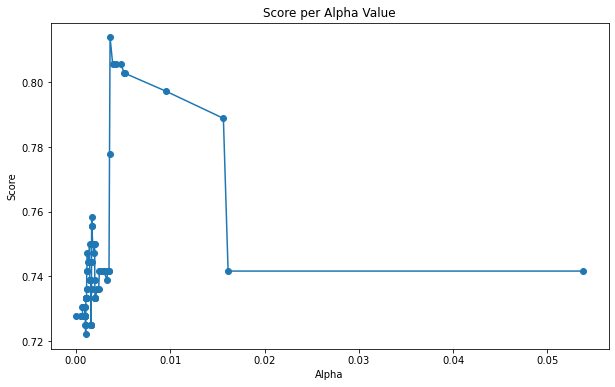

In [56]:
plt.rcParams["figure.figsize"] = [10.0, 6.0]

fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Score")
ax.set_title("Score per Alpha Value")
ax.plot(cost_path.ccp_alphas, subtree_scores, marker="o")
plt.show()

In [57]:
slice_ind = slice(-11, -7)
ccp_alphas_slice = cost_path.ccp_alphas[slice_ind]
subtrees_slice = subtrees[slice_ind]

In [58]:
subtree_scores = [subtree.score(X_test, y_test) for subtree in subtrees_slice]

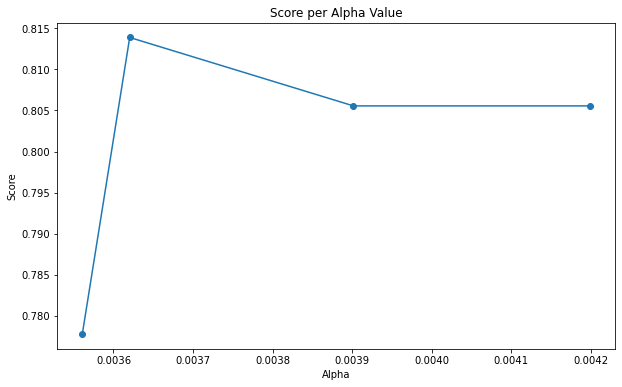

In [59]:
plt.rcParams["figure.figsize"] = [10.0, 6.0]

fig, ax = plt.subplots()
ax.set_xlabel("Alpha")
ax.set_ylabel("Score")
ax.set_title("Score per Alpha Value")
ax.plot(ccp_alphas_slice, subtree_scores, marker="o")
plt.show()

In [60]:
alpha_scores = tuple(zip(ccp_alphas_slice, subtree_scores))
alpha_scores

((0.0035608327131500367, 0.7777777777777778),
 (0.0036204337279606112, 0.8138888888888889),
 (0.0039017863882576803, 0.8055555555555556),
 (0.004198705591911059, 0.8055555555555556))

In [61]:
print(max(alpha_scores, key=lambda x:x[1]))

(0.0036204337279606112, 0.8138888888888889)


In [62]:
subtrees[-10]

DecisionTreeClassifier(ccp_alpha=0.0036204337279606112, random_state=14)

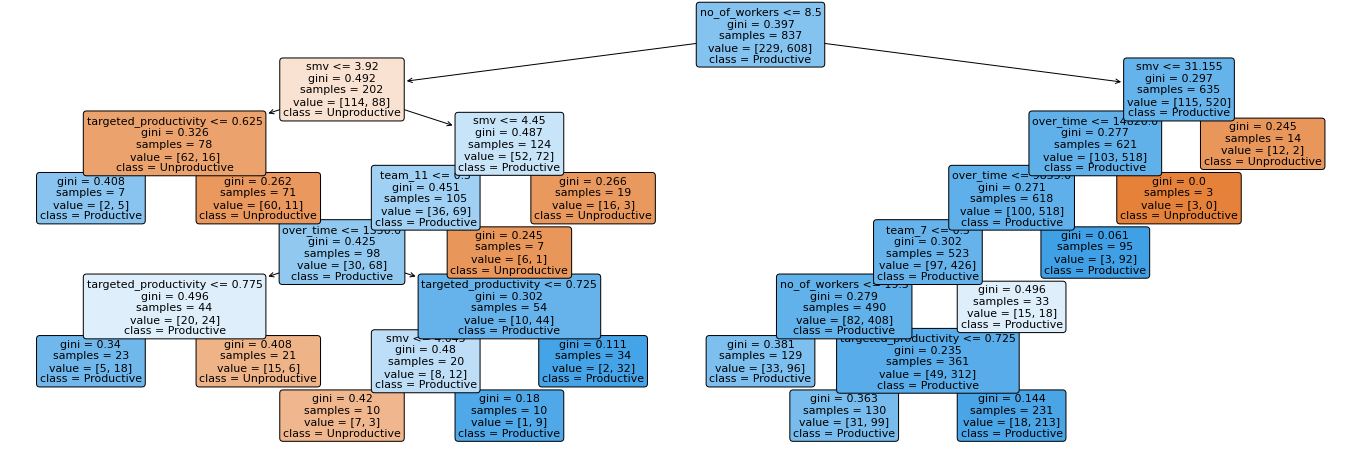

In [63]:
plt.figure(figsize = [24.0, 8.0])

_ = plot_tree(subtrees[-10], 
    feature_names = X.columns,
    class_names = ['Unproductive', 'Productive'], # had to input these manually, as the input classes are boolean
    filled = True,       
    proportion = False,
    precision = 3,
    rounded = True,
    fontsize = 11)

plt.show()

This model had similar accuracy to our previous model--81%--but it also has a depth of 7, which makes it a little harder to parse. 

## Random Forest Models

### Random Forest

In [64]:
garment_forest = RandomForestClassifier(criterion="entropy", max_depth=3, min_samples_leaf=12, min_samples_split=36, random_state=444, n_jobs=-1, n_estimators=15, oob_score=True)
garment_forest.fit(X_train, y_train)
garment_forest_score = garment_forest.score(X_test, y_test)
print(f"Accuracy: {round(garment_forest_score, 3)}")
garment_forest_oob = garment_forest.oob_score_
print(f"OOB: {round(garment_forest_oob, 3)}")

Accuracy: 0.789
OOB: 0.772


### Extra Trees

In [65]:
extra_tree_class = ExtraTreesClassifier(criterion="entropy", max_depth=3, min_samples_leaf=12, min_samples_split=36, random_state=444, n_jobs=-1, n_estimators=15)
extra_tree_crossval = cross_val_score(extra_tree_class, X, y, cv = 10, n_jobs = -1)

In [66]:
extra_tree_crossval_mean = extra_tree_crossval.mean()
print(extra_tree_crossval, extra_tree_crossval_mean, sep='\n')

[0.73333333 0.73333333 0.75       0.73333333 0.73333333 0.725
 0.725      0.73109244 0.73109244 0.73109244]
0.7326610644257704


Neither the random forest or extra trees approach added any accuracy to our prediction, so our original best tree is probably the one to make conclusions off of. However, the similarity of accuracy in these latter trees can give us more confidence in our model.

## Conclusions

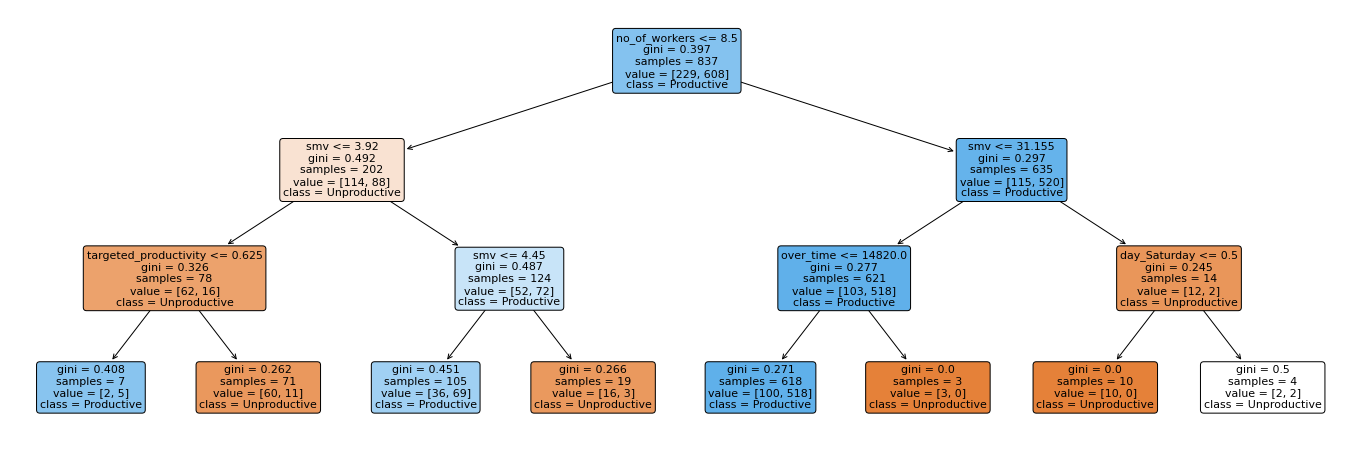

In [67]:
plt.figure(figsize = [24.0, 8.0])

_ = plot_tree(garment_class_tree, 
    feature_names = X.columns,
    class_names = ['Unproductive', 'Productive'], # had to input these manually, as the input classes are boolean
    filled = True,       
    proportion = False,
    precision = 3,
    rounded = True,
    fontsize = 11)

plt.show()

This tree illustrates which aspects of the garment factory are best at predicting whether a team will be productive or not--that is, whether it will meet or exceed its productivity goals. Many aspects were included in the model, including things like the quarter in which a project was accomplished, the number of workers on a team, specific team number, department, day of the week, and more. 

To orient you, every leftward branch in the figure indicates that the criterion listed at the top of the box is true, and every rightward branch means that criterion is false for the sample. The bottom-most nodes are the most important, as these are where our final bins come from, with each bin having a certain number of projects in it (labelled as "samples"), being labelled as productive or unproductive (at the bottom of the box), and each one satisfying all the criteria of the nodes branching down to it. For instance, the bottom left-most node with 7 samples comprises projects with fewer than 8.5 workers, SMV less than 3.92, and targeted productivity less than 0.625. Projects meeting these criteria were predicted to be productive. 

Our model was 80% accurate at predicting the true productivity from our data set of roughly 840 projects. So although it is not perfect, our model has good predictive power.

Our model shows that SMV--the time allocated for a task--has the greatest influence on productivity. In teams with fewer than 9 people, having an SMV between 4 and 4.4 tended to create the most productivity (105 projects, 13% of dataset). In teams with 9+ people, having an SMV less than 31 led to the most productivity (618 projects, 74% of dataset). The feature most predictive of projects being unproductive was targeted productivity, which when combined with small temas and low SMV, showed the largest predictions for being unproductive (71 projects, 8.5% of dataset). SMV larger than 4.5 with small teams also contributed to projects being unproductive (19 projects, 2% of dataset). 

To summarize, larger teams with lower SMV were predicted to be most productive, and smaller teams with a very specific SMV (4 to 4.4) were also predicted to be very productive. Unproductivity was best predicted by having small teams, low SMV, and high targeted productivity. This model can be used to calibrate future expectations from teams. It suggests that smaller teams may have greater productivity if productivity targets are decreased for projects with low SMV. Also, the model suggests that dedicating more resources to large SMV projects on large teams may lead to higher productivity.